<a href="https://colab.research.google.com/github/vinay-pv/DA231o-Stock-Indicators/blob/main/Data_Riggers_Stock_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
import os.path

if not os.path.exists('/content/drive/MyDrive'):
  drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
if not os.path.exists('/content/spark-3.0.3-bin-hadoop2.7'):
  !tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install -q pyarrow 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

Mounted at /content/drive


In [ ]:
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark

findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

**Stock Analysis Framework Clases**

This Framework is design to implement the Stock Analysis. 
Below are the list of features for Stock Analysis.
1. Stock Indicators which generated use Big Data based technologies Apache Spark. Which can be scale out system dynamically easily compared to traditional standalone approach.
2. Features to yet to addeed 

Below are the list of classes Implemented for for Stock Analysis & Indicators


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Import Needed Framework 
from pyspark.sql.types import *
from pyspark.sql import Window
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns


from pyspark.sql.functions import stddev
from pyspark.sql.functions import lit


from pyspark.sql.functions import col, expr, when
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import *
plt.figure(figsize=(20, 10))


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [ ]:
#######################################
###!@2 START OF DEFINING INPUT FILES
from pyspark.sql.types import *
from pyspark.sql.functions import col

pfile = "/content/drive/MyDrive/DA231-Data-Riggers/HEROMOTOCO_minute_data_with_indicators.csv"
#pfile = "/content/drive/MyDrive/DA231-Data-Riggers/TATAMOTORS_minute_data_with_indicators.csv"
###!@2 END OF DEFINING INPUT FILES


#######################################
###!@3 START OF LOADING DATA

##########################
# load pollution data from CSV
#_pdf = spark.read.option("header",True).option("inferSchema",True).csv(pfile)
#_pdf.printSchema()
#_pdf.show(20)
#_pdf.count()
#!head -1000 "/content/drive/MyDrive/DA231-Data-Riggers/HEROMOTOCO_minute_data_with_indicators.csv"

###!@3 END OF LOADING DATA

In [ ]:
from datetime import datetime

def plot_line_graph(dataFrame, originalColName, targetColName, targetColName1=None,targetColName2=None, duration=1):
    date = "date"
    duration = 44 + duration
    #start_date_dt = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    pdf = dataFrame.filter((F.col(date) > F.date_sub(F.current_date(), duration))).toPandas()
    #pdf = dataFrame.filter((F.col(date) > F.date_sub(start_date_dt, duration))).toPandas()
    pdf[date]= pd.DatetimeIndex(pdf[date])
    
    ax = pdf.plot(x=date, y=originalColName, legend=False, figsize=(20,10))
    ax2 = ax.twinx()
    pdf.plot(x=date, y=targetColName, ax=ax2, legend=False, color="r")
    if(targetColName1 !=None) :
      pdf.plot(x=date, y=targetColName1, ax=ax2, legend=False, color="g")
    if(targetColName2 !=None) :
      pdf.plot(x=date, y=targetColName2, ax=ax2, legend=False, color="y")
    ax.figure.legend()
    ax.set_title("Comparison line plot")
    plt.show()

In [ ]:
lastEMA =  spark.sparkContext.accumulator(0.0)
# Main Data Processing Object for check Stock: Spark DF Based
class DFObj:
    def __init__(self, dfObj=None,  pyDF=None, csvFile=None):
        if dfObj and isinstance(dfObj, DFObj):
            self.df = dfObj.alias('df2')
        elif pyDF and isinstance(pyDF, DataFrame):
            self.df = pyDF.select()
        elif csvFile:
            self.df = spark.read.option("header", True).option("inferSchema", True).csv(csvFile)
            self.df = self.df.withColumn("date", F.to_timestamp(col("date")))
        else:
            self.df = None #spark.emptyDataFrame()
    def plot(self, plIndList, sDuration=None, eDuration=None):
      if not sDuration:
        #max_date = self.df.max(col("date"))
        #sDuration = F.date_sub(max_date, 1000)
        #eDuration = max_date
        sDuration = F.date_sub(F.current_timestamp(), 45+29)
        eDuration = F.current_timestamp()
      print("sDuration")
      print(sDuration)
      print(eDuration)
      pdf = self.df.filter((F.col('date') > sDuration) & (F.col('date') <= eDuration)).toPandas()
      print(pdf.shape)
      pdf.set_index('date')
      fig, ax = plt.subplots()
      for key in plIndList:
        ax.plot(pdf["date"],pdf[key], label=key)
      ax.set_ylabel('Price')
      plt.legend(loc='close')
      plt.show()




def get_CurEMA(clVal, rEMAMult,pEMAMult):
  global lastEMA
  if (lastEMA.value != 0.0):
    lastEMA.value = (clVal*rEMAMult)+(lastEMA*pEMAMult)
    return lastEMA.value
  else:
    lastEMA.value = (clVal*rEMAMult)+(clVal*pEMAMult) 
    return lastEMA.value

class AnalysisDF:
    # OverLap Studies
    BBANDS = "BBANDS"
    DEMA = "DEMA"
    EMA = "EMA"
    HT_TRENDLINE = "HT_TRENDLINE"
    KAMA = "KAMA"
    MA = "MA"
    MAMA = "MAMA"
    MAVP = "MAVP"
    MIDPOINT = "MIDPOINT"
    MIDPRICE = "MIDPRICE"
    SAR = "SAR"
    SAREXT = "SAREXT"
    SMA = "SMA"
    T3 = "T3"
    TEMA = "TEMA"
    TRIMA = "TRIMA"
    WMA = "WMA"
    ATR = "ATR"

    # Supported Analysis Type
    aSupportType = [SMA, EMA, KAMA, TRIMA, ATR,BBANDS]

    def isSupport( aType):
        if aType in AnalysisDF.aSupportType:
            return True
        return False

    def genSMA(DFObj, rhrs=5, withColName=None):
        genColName = AnalysisDF.SMA
        if withColName:
           genColName = withColName
        w = Window.orderBy(DFObj.df.date).rowsBetween(-rhrs, Window.currentRow)
        DFObj.df = DFObj.df.withColumn(genColName, F.avg("close").over(w))
        return DFObj

    def genTRIMA(DFObj, rhrs=5, withColName=None):
        genColName = AnalysisDF.TRIMA
        if withColName:
           genColName = withColName
        AnalysisDF.genSMA(DFObj, rhrs=1, withColName="tSMA1")
        AnalysisDF.genSMA(DFObj, rhrs=1, withColName="tSMA2")
        AnalysisDF.genSMA(DFObj, rhrs=1, withColName="tSMA3")
        AnalysisDF.genSMA(DFObj, rhrs=1, withColName="tSMA4")
        AnalysisDF.genSMA(DFObj, rhrs=1, withColName="tSMA5")  
        DFObj.df = DFObj.df.withColumn(genColName, (col("tSMA1")+col("tSMA2")+col("tSMA3")+col("tSMA4")+col("tSMA5"))/5) \
                    .drop("tSMA1","tSMA2","tSMA3","tSMA4","tSMA5")
        return DFObj

    def genATR(DFObj, tRange = 14, withColName=None):
        return AnalysisDF.genTRIMA(DFObj, withColName=withColName)
        genColName = AnalysisDF.ATR
        if withColName:
           genColName = withColName
        DFObj.df = DFObj.df.withColumn("high_low", col('high') - col('low'))
        DFObj.df = DFObj.df.withColumn("high_close", col('high') - col('close'))
        DFObj.df = DFObj.df.withColumn("low_close", col('low') - col('close'))
        DFObj.df.count()
        DFObj.df = DFObj.df.withColumn('ranges', F.greatest(col('high_low'), col('high_close'), col('low_close')))
        DFObj.df.count()
        w = Window.orderBy(DFObj.df.date).rowsBetween(-tRange, Window.currentRow)
        DFObj.df = DFObj.df.withColumn(genColName, F.avg(col('ranges')).over(w)).drop("high_low","high_close","low_close","ranges") #.toPandas()
        DFObj.df.show(5)

        #atr = true_range.rolling(tRange).avg() 
        #DFObj.df = DFObj.df.withColumn(genColName, atr)
        return DFObj

    def genKAMA(DFObj, n=10, pow1=2, pow2=30,withColName=None ):
      return AnalysisDF.genTRIMA(DFObj, withColName=withColName)
      genColName = AnalysisDF.KAMA
      price = DFObj.df.select("close").collect()
      absDiffx = abs(price - F.lag(price,1) )  

      ER_num = abs( price - price.shift(n) )
      ER_den = pd.stats.moments.rolling_sum(absDiffx,n)
      ER = ER_num / ER_den

      sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0
      answer = np.zeros(sc.size)
      N = len(answer)
      first_value = True

      for i in range(N):
          if sc[i] != sc[i]:
              answer[i] = np.nan
          else:
              if first_value:
                  answer[i] = price[i]
                  first_value = False
              else:
                  answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
      
      DFObj.df = DFObj.df.withColumn(genColName, answer)
      return DFObj

    def genEMA(DFObj, rhrs=5, withColName=None, rEMAMult=None):
        genColName = AnalysisDF.EMA
        if not rEMAMult:
          rEMAMult = (2.0/(rhrs+1))
          pEMAMult = 1 - rEMAMult
        if withColName:
           genColName = withColName
        lastEMA.value=0.0

        udf_func = udf(get_CurEMA,DoubleType()) #Creating a 'User Defined Function' to calculate distance between two points.
        w = Window.orderBy(DFObj.df.date)
        DFObj.df = DFObj.df.withColumn(genColName, get_CurEMA(col("close"), rEMAMult, pEMAMult))
        return DFObj
    def genBBands(DFObj, window=20,withColName=None ):
      genColName = AnalysisDF.BBANDS
      colNameMA  = AnalysisDF.BBANDS+"MA"
      colNameHigh = AnalysisDF.BBANDS +"U"
      colNameLow = AnalysisDF.BBANDS  + "L"
      AnalysisDF.genSMA(DFObj, rhrs=window, withColName=colNameMA)
      std = DFObj.df.select(stddev(colNameMA)).collect()[0][0]
      print(std)

      DFObj.df = DFObj.df.withColumn(colNameHigh, (col(colNameMA) + lit(std) ))
      DFObj.df = DFObj.df.withColumn(colNameLow, (col(colNameMA) - lit(std) ))
      return DFObj

    
    def genIndicators(DFObj, indList):
      aSupportCB = {AnalysisDF.SMA:AnalysisDF.genSMA, AnalysisDF.EMA:AnalysisDF.genEMA}
      for ind in indList:
        print(ind)
        print(aSupportCB) 
        aSupportCB[ind](DFObj)

In [ ]:
# Test Stock Analysis Framework


pfile = "/content/drive/MyDrive/DA231-Data-Riggers/HEROMOTOCO_minute_data_with_indicators.csv"
#oDF = DFObj(csvFile=pfile)
#oDF.df.printSchema()
oDF = DFObj(csvFile=pfile)



sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 60)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


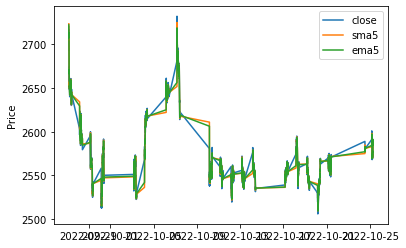

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
sDF.plot(plIndList = ["close","sma5","ema5"])

**Simple Moving Average (SMA)**

 SMA is simply the mean, or average, of the stock price values over the specified period. 

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/sma#:~:text=Simple%20Moving%20Average%20(SMA)&text=It%20is%20simply%20the%20average,as%20the%20average%20value%20changes.

sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 63)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


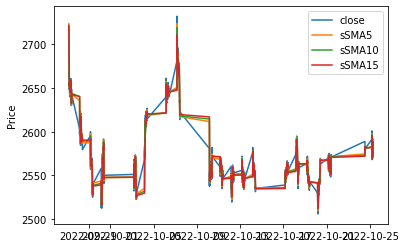

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
AnalysisDF.genSMA(sDF, rhrs=5, withColName="sSMA5")
AnalysisDF.genSMA(sDF, rhrs=10, withColName="sSMA10")
AnalysisDF.genSMA(sDF, rhrs=15, withColName="sSMA15")
sDF.plot(plIndList = ["close","sSMA5","sSMA10","sSMA15"])

Exponential Moving Average (EMA)

Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current. 

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema#:~:text=Exponential%20Moving%20Average%20(EMA)%20is,data%20that%20is%20more%20current.

sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 63)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


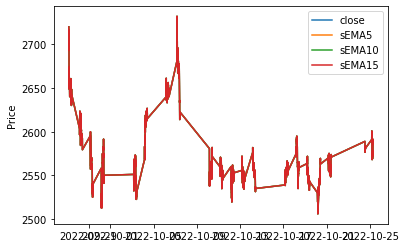

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
AnalysisDF.genEMA(sDF, rhrs=5, withColName="sEMA5")
AnalysisDF.genEMA(sDF, rhrs=10, withColName="sEMA10")
AnalysisDF.genEMA(sDF, rhrs=15, withColName="sEMA15")
sDF.plot(plIndList = ["close","sEMA5","sEMA10","sEMA15"])

**Bollinger Bands**

Bollinger Bands® are composed of three lines. One of the more common calculations uses a 20-day simple moving average (SMA) for the middle band. The upper band is calculated by taking the middle band and adding twice the daily standard deviation to that amount. The lower band is calculated by taking the middle band minus two times the daily standard deviation.

https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Calculation%20of%20Bollinger%20Bands,-Bollinger%20Bands%C2%AE&text=The%20upper%20band%20is%20calculated,times%20the%20daily%20standard%20deviation

463.60540593952686
sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 63)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


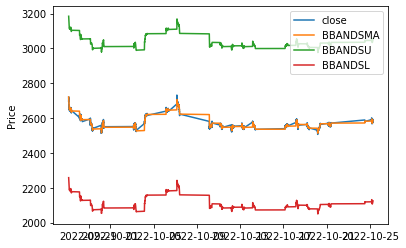

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
AnalysisDF.genBBands(sDF)
sDF.plot(plIndList = ["close","BBANDSMA", "BBANDSU", "BBANDSL"])

**Kaufman’s Adaptive Moving Average (KAMA)**

Kaufman’s Adaptive Moving Average accounts not only for price action but also for market volatility

https://corporatefinanceinstitute.com/resources/equities/kaufmans-adaptive-moving-average-kama/

sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 61)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


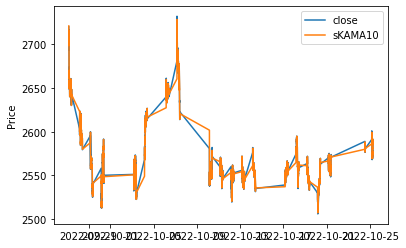

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
AnalysisDF.genKAMA(sDF, withColName="sKAMA10")
sDF.plot(plIndList = ["close","sKAMA10"])

**Triangular Moving Average (TRIMA)**

The triangular moving average (TMA) is a weighted average of the last n prices (P), whose result is equivalent to a double smoothed simple moving average:

SMA = (P1 + P2 + P3 + P4 + ... + Pn) / n

TMA = (SMA1 + SMA2 + SMA3 + SMA4 + ... SMAn) / n

https://www.barchart.com/education/technical-indicators/moving_average_triangular#:~:text=The%20triangular%20moving%20average%20(TMA)%20is%20a%20weighted%20average%20of,%2B%20Pn)%20%2F%20n

sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 61)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


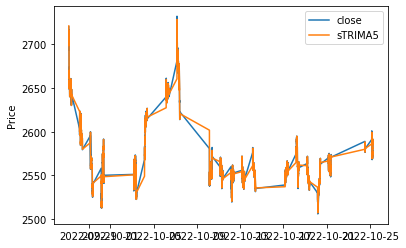

In [ ]:
sDF = DFObj()
sDF.df = oDF.df
AnalysisDF.genTRIMA(sDF, withColName="sTRIMA5")
sDF.plot(plIndList = ["close","sTRIMA5"])

**Combined Data Indicators**

SMA, EMA, KAMA, TRIMA, ATR

sDuration
Column<b'date_sub(current_timestamp(), 74)'>
Column<b'current_timestamp()'>
(7007, 68)


<ipython-input-6-faea8af6dfb9>:31: MatplotlibDeprecationWarning: Unrecognized location 'close'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='close')


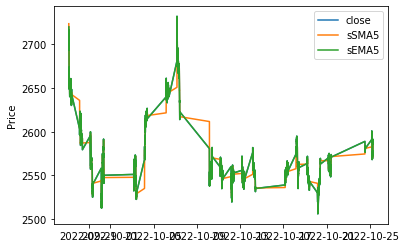

In [ ]:

sDF = DFObj()
sDF.df = oDF.df
#sDF.df.show(3)
lastEMA.value=0.0
AnalysisDF.isSupport(AnalysisDF.SMA)
AnalysisDF.genATR(sDF, withColName="sATR")
#sDF.df.show(20)
AnalysisDF.genSMA(sDF)
AnalysisDF.genSMA(sDF, rhrs=5, withColName="sSMA5")
AnalysisDF.genSMA(sDF, rhrs=10, withColName="sSMA10")
AnalysisDF.genSMA(sDF, rhrs=15, withColName="sSMA15")
AnalysisDF.genEMA(sDF, rhrs=5,  withColName="sEMA5")
AnalysisDF.genEMA(sDF, rhrs=10, withColName="sEMA10")
AnalysisDF.genEMA(sDF, rhrs=15, withColName="sEMA15")
#AnalysisDF.genKAMA(sDF, withColName="sKAMA10")
#AnalysisDF.genTRIMA(sDF, withColName="sTRIMA5")
#sDF.df.show(20)
sDF.df.count()

sDF.plot(plIndList = ["close","sSMA5","sEMA5"])


## **ML Pipleline** 

To evaluate the generated column value prediction with respect to ground truth **close** column values of the stock

In [ ]:
#Import statements
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.feature import StringIndexer, OneHotEncoder,  VectorAssembler, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

In [ ]:
#Graph Plot
def plot_graph(predictions, original, target, metric):
    x_ax = range(0, predictions.count())
    y_pred=predictions.select(target).collect()
    y_orig=predictions.select(original).collect()
    plt.plot(x_ax, y_orig, label="Original Close Value")
    plt.plot(x_ax, y_pred, label="Predicted Close Value")
    plt.title("Predicted close value for %s evaluation" %metric)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.figaspect(2.)
    plt.show()

In [ ]:
#Mode Evaluation
def evaluateModel(model, target, predicted, metric):
    # Use RegressionEvaluator to evaluate the predicted model
    evaluator = RegressionEvaluator(labelCol="close", predictionCol=predicted, metricName=metric)
    score = evaluator.evaluate(model)
    print("Evaluation Score = %g" % score)

In [ ]:
#Mode Creation
def createModel(featuresList, targetList):
    
    # Create feature vector 
    assembler = VectorAssembler(inputCols=featuresList, outputCol='target')
    df_assembled = assembler.setHandleInvalid("skip").transform(sDF.df)
    
    # Split data into training and test sets 
    #train, test = df_assembled.randomSplit([0.85, 0.15], seed=42)

    rankDf = df_assembled.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))
    train = rankDf.where("rank <= .8").drop("rank")
    #train.show(5)
    test = rankDf.where("rank > .8").drop("rank")
    #test.show(5)
    
    trees = 10
    
    # Create Random Forest Classifier model 
    rf = RandomForestRegressor(labelCol="close", featuresCol="target", numTrees=trees)
    
    # Chain indexers and forest in a Pipeline
    pipeline = Pipeline(stages=[rf])
    
    # Train model.  This also runs the indexers.
    model = pipeline.fit(train)
    
    # Make predictions.
    predictions = model.transform(test)
    
    # Select example rows to display.
    predictions.select("target", "close").show(5)
    
    return predictions

## Testing Code for generated regression model

ML Algo used : Random Forest Regression. \
Evaluation : Regression Evaluator. \
Evaluation metric : R2 (coefficient of determination) - is a statistical measure of how well the regression predictions approximate the real data points

In [ ]:
# Select features and target variable 
features = ['high', 'low', 'open', 'volume', 'sma5', 'sma10', 'ema5', 'ema10', 'upperband', 'middleband', 'lowerband', 'KAMA10', 'ADX10', 'ROC10']
target = ['close']

# Make a prediction
predictions = createModel(features, target)

+--------------------+-------+
|              target|  close|
+--------------------+-------+
|[2912.8,2908.1,29...| 2908.5|
|[2908.5,2905.0,29...| 2906.0|
|[2907.95,2905.85,...|2907.95|
|[2908.65,2907.15,...|2908.35|
|[2910.6,2907.55,2...| 2910.0|
+--------------------+-------+
only showing top 5 rows



In [ ]:
"""
For num_of_trees = 100

Evaluation R-Square Metric:
Score = 0.984249

Evaluation Root Mean Square Error:
Score = 24.1996

Evaluation Mean Absolute Error:
Score = 18.7415
"""

#Evaluate the model with R2 metric
print("R2:")
eval_metric = "r2"
evaluateModel(predictions, "close", "prediction", eval_metric)


#Evaluate the model with RMSE metric
print("\nRoot Mean Square Error:")
eval_metric = "rmse"
evaluateModel(predictions, "close", "prediction", eval_metric)

#Plot the graph for last 30 days
print("\n")
plot_line_graph(dataFrame=predictions, originalColName='close', targetColName='prediction', duration=30)

R2:
Evaluation Score = 0.987656

Root Mean Square Error:
Evaluation Score = 21.4237




Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.0.3-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38455)
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-dbcb6428b040>", line 27, in <module>
    plot_line_graph(dataFrame=

Py4JError: ignored

In [ ]:
# Select features and target variable 
features = ['high', 'low', 'open', 'volume', 'sSMA5', 'sSMA10', 'sEMA5', 'sEMA10']
target = ['close']

# Make a prediction
ourpred = createModel(features, target)

In [ ]:
#Evaluate the model with R2 metric
print("Evaluation R-Square Metric:")
eval_metric = "r2"
evaluateModel(ourpred, "close", "prediction", eval_metric)


#Evaluate the model with RMSE metric
print("\nEvaluation Root Mean Square Error:")
eval_metric = "rmse"
evaluateModel(ourpred, "close", "prediction", eval_metric)

#Plot the graph for last 30 days
print("\n")
plot_line_graph(dataFrame=ourpred, originalColName='close', targetColName='prediction', duration=30)